In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

Main Problems:
 - Very noisy data, we expect relatively low R-squared even with a perfect model
 - Large feature space means we will be prone to overfitting, feature selection & regularization will be important
 - We have several highly influential points
 
Plan:
 - Because of our skewed response variable, we should predict log(y)
 - Fit a full model to understand outliers and influential points, prune these points
 - Next, try feature selection to compare full model, mixed selection model, and PCA model
 - For each model, run diagnostics to see which meets assumptions the best, R-squared, etc.

# Section 1: Baseline Model and Identification of Influential Points

In [330]:
df = pd.read_csv('data/clean_fire_data.csv').drop(columns=['Unnamed: 0'])
df['start_date'] = pd.to_datetime(df['start_date']).astype('int64')/(10**9)
reg_df = df.drop(columns=['incident name', 'ID']) # drop columns like name of incident, ID for model fitting
response = 'size'
features = reg_df.columns.drop(response) 
numerical_features = reg_df.columns.drop([response, 'fully_contained', 'geographic_area', 'weather', 'weather_description'])

Text(0.5, 1.0, 'Correlation Table for Fire & Weather Data')

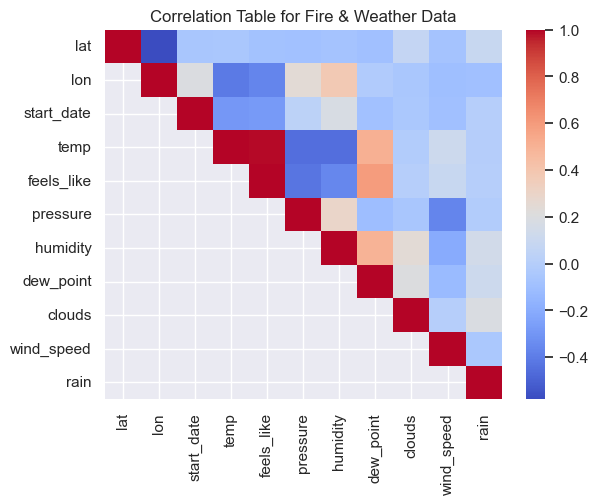

In [334]:
corr_table = reg_df[numerical_features].corr() 
sns.heatmap(corr_table, annot=False, cmap='coolwarm', mask=np.tril(corr_table, k=-1))
plt.title('Correlation Table for Fire & Weather Data')

In [322]:
baseline_formula = f'np.log({response}) ~ {" + ".join(features)}'
baseline_model = smf.ols(baseline_formula, data=reg_df).fit()

In [323]:
non_collinear_features = reg_df.columns.drop([response, 'feels_like', 'dew_point']) 
non_collinear_formula = f'np.log({response}) ~ {" + ".join(non_collinear_features)}'
non_collinear_model = smf.ols(non_collinear_formula, data=reg_df).fit()

Text(0.5, 1.0, "Cook's Distance Influence Plot")

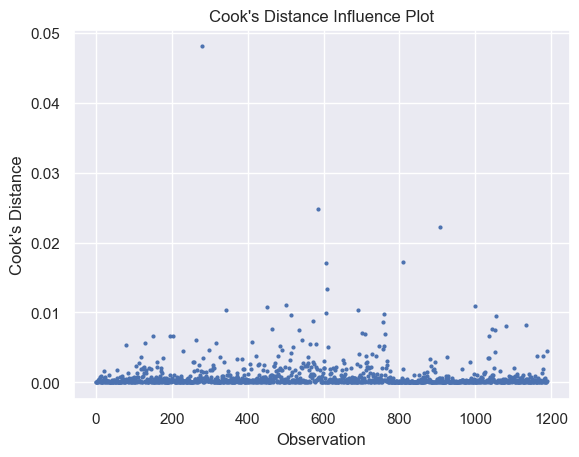

In [269]:
yval = influence_summary['cooks_d']
xval = range(len(yval))
plt.scatter(xval, yval, s=4)
plt.xlabel('Observation')
plt.ylabel('Cook\'s Distance')
plt.title('Cook\'s Distance Influence Plot')

# Section 2: Feature Selection

In [284]:
covariates = baseline_model.params.index
penalties = {k:[] for k in covariates}
for lamb in np.arange(0.01,1.01,0.01):
    elastic_fit = smf.ols(f'{response} ~ {" + ".join(features)}', data=reg_df).fit_regularized(method='elastic_net', alpha=1.0, L1_wt=lamb)
    for i, cov in enumerate(covariates):
        penalties[cov].append(elastic_fit.params[cov])

In [287]:
covariates

Index(['Intercept', 'fully_contained[T.True]', 'geographic_area[T.EACC]',
       'geographic_area[T.GBC]', 'geographic_area[T.NRC]',
       'geographic_area[T.NWCC]', 'geographic_area[T.ONCC]',
       'geographic_area[T.RMC]', 'geographic_area[T.SAC]',
       'geographic_area[T.SWC]', 'weather[T.Clouds]', 'weather[T.Other]',
       'weather[T.Rain]', 'weather_description[T.clear sky]',
       'weather_description[T.few clouds]',
       'weather_description[T.light rain]',
       'weather_description[T.moderate rain]', 'weather_description[T.other]',
       'weather_description[T.overcast clouds]',
       'weather_description[T.scattered clouds]', 'lat', 'lon', 'start_date',
       'temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'clouds',
       'wind_speed', 'rain'],
      dtype='object')

In [294]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Text(0.5, 1.0, 'Scree Plot for PCA')

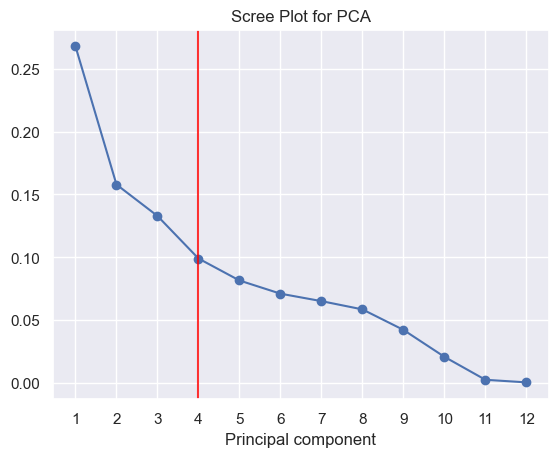

In [298]:
X = reg_df.drop(['size', 'geographic_area', 'weather', 'weather_description'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)

Z = pca.transform(X_scaled)
# scree plot
plt.plot(range(1, X_scaled.shape[1] + 1), (pca.explained_variance_ratio_), marker='o')
plt.xticks(np.arange(1, X_scaled.shape[1] + 1, 1))
plt.xlabel('Principal component')
plt.axvline(4, color=(1,0,0,0.8))
plt.title('Scree Plot for PCA')

In [300]:
q = 4
pca_X = -pca.transform(X_scaled)[:,:q]
pca_df = pd.DataFrame(pca_X, columns=['Z1', 'Z2', 'Z3', 'Z4'])
pca_df[response] = df[response]
pca_df.head()

,Z1,Z2,Z3,Z4,size
0,-1.590967,-0.000784,-0.188524,1.477598,436.0
1,-1.966640,-0.930763,0.685205,0.948164,182.0
2,0.844264,1.360173,0.539251,-0.916862,695.0
3,-1.212056,-2.110484,0.782457,1.614963,475.0
4,-3.068773,0.000601,-1.348723,0.845469,888.0


In [308]:
pca_fit = smf.ols('size ~ Z1 + Z2 + Z3 + Z4', pca_df).fit()
print(pca_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   size   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4075
Date:                Sat, 08 Jun 2024   Prob (F-statistic):              0.803
Time:                        15:17:11   Log-Likelihood:                -14025.
No. Observations:                1190   AIC:                         2.806e+04
Df Residuals:                    1185   BIC:                         2.809e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3349.5439    923.248      3.628      0.0

In [309]:
from sklearn.manifold import TSNE

In [315]:
tsne = TSNE(n_components=3, perplexity=30)
tsne_X = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(tsne_X, columns=['T1', 'T2', 'T3'])
tsne_df[response] = df[response]
tsne_df.head()

,T1,T2,T3,size
0,2.197146,-3.377995,-3.673908,436.0
1,1.892203,-1.876614,-1.662633,182.0
2,-3.406109,-2.643029,-11.452999,695.0
3,1.607771,-0.338011,-2.325649,475.0
4,-2.687085,-4.099977,0.502760,888.0


In [316]:
tsne_fit = smf.ols('size ~ T1 + T2 + T3', tsne_df).fit()
print(tsne_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   size   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4798
Date:                Sat, 08 Jun 2024   Prob (F-statistic):              0.696
Time:                        15:19:03   Log-Likelihood:                -14025.
No. Observations:                1190   AIC:                         2.806e+04
Df Residuals:                    1186   BIC:                         2.808e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3367.7236    924.827      3.641      0.0